# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
import time
import librosa # optional, only needed to convert MIDI keys to notes

## Path to dataset

In [2]:
DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/'
DATA_PATH+= '/diverse/sub-matthias_ses-S001_task-Default_run-001_diverse.xdf'

In [3]:
# Read in the LSL streams from the XDF file
START_TIME = time.time()
streams, header = pyxdf.load_xdf(DATA_PATH) # this could take ~80 seconds..
print(f'Loaded in {time.time() - START_TIME} s')

Loaded in 127.18994975090027 s


In [5]:
streams[3]

{'info': defaultdict(list,
             {'name': ['ev_ts'],
              'type': ['timestamp'],
              'channel_count': ['1'],
              'channel_format': ['double64'],
              'source_id': [None],
              'nominal_srate': ['1.000000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['23680.13848005700'],
              'uid': ['432d3202-55cc-46e2-abf3-10b6fc5ba162'],
              'session_id': ['default'],
              'hostname': ['suman-ThinkPad-P14s-Gen-1'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [None],
              'stream_id': 2,
              'effective_srate': 0.9998510446086848}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['27212.626183671'],
               'last_times

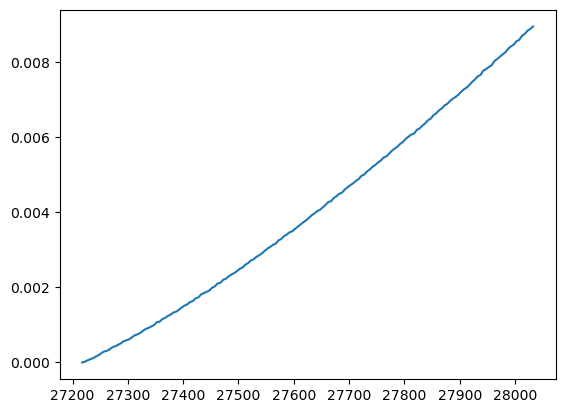

In [25]:
values = [float(x['value'][0]) for x in streams[3]['footer']['info']['clock_offsets'][0]['offset']]
times = [float(x['time'][0]) for x in streams[3]['footer']['info']['clock_offsets'][0]['offset']]

#plt.plot(times[1:], np.diff(values))
plt.plot(times, np.array(values)-values[0])

In [6]:
streams[3]['time_stamps']

array([627326.30129363, 627327.30144279, 627328.30159195, 627329.30174111,
       627330.30189027, 627331.30203943, 627332.30218859, 627333.30233775,
       627334.30248691, 627335.30263607, 627336.30278523, 627337.30293439,
       627338.30308355, 627339.30323271, 627340.30338187, 627341.30353103,
       627342.30368019, 627343.30382935, 627344.30397851, 627345.30412767,
       627346.30427683, 627347.30442599, 627348.30457515, 627349.30472431,
       627350.30487347, 627351.30502263, 627352.30517179, 627353.30532095,
       627354.30547011, 627355.30561927, 627356.30576843, 627357.30591759,
       627358.30606675, 627359.30621591, 627360.30636507, 627361.30651423,
       627362.30666339, 627363.30681255, 627364.30696171, 627365.30711087,
       627366.30726003, 627367.30740919, 627368.30755835, 627369.30770751,
       627370.30785667, 627371.30800583, 627372.30815499, 627373.30830415,
       627374.30845331, 627375.30860248, 627376.30875164, 627377.3089008 ,
       627378.30904996, 6

## Check the duration of each recorded stream

In [26]:
for s in streams:
    name = s['info']['name']
    
    # the footer timestamps might be coming from different machines?
    first_timestamp = float(s['footer']['info']['first_timestamp'][0])
    last_timestamp = float(s['footer']['info']['last_timestamp'][0])
    print(name, first_timestamp, last_timestamp, last_timestamp -first_timestamp)
    
    # These seem more comparable
    print(s['time_stamps'][0])

['CGX Quick-32r Q32r-0524 Impedance'] 627325.377451 628142.3856054 817.0081543999258
627325.2739816022
['CGX Quick-32r Q32r-0524'] 627325.3774481 628142.3856052 817.0081570999464
627325.2739802459
['glove_data'] 17778.843508791 18595.921497388 817.0779885970005
627325.3522151901
['ev_ts'] 27212.626183671 28028.739800553 816.1136168820012
627326.3012936276
['MIDIStream'] 17813.922145359 18571.476104105 757.5539587460007
627360.4304148377
['MyAudioStream'] 627325.4127071757 628139.2895727557 813.8768655799795
627325.3077660879


In [27]:
# Get the first time stamp across all streams (read from time_stamps)
first_timestamps = []

for s in streams: # loop through remaining streams
    s_name = s['info']['name']
    t0 = s['time_stamps'][0]
    print(t0, '\t', s_name)
    
    first_timestamps.append(t0)
    
first_timestamp = min(first_timestamps)
print(first_timestamp, '\t', '<== earliest')   

627325.2739816022 	 ['CGX Quick-32r Q32r-0524 Impedance']
627325.2739802459 	 ['CGX Quick-32r Q32r-0524']
627325.3522151901 	 ['glove_data']
627326.3012936276 	 ['ev_ts']
627360.4304148377 	 ['MIDIStream']
627325.3077660879 	 ['MyAudioStream']
627325.2739802459 	 <== earliest


# Collect stream info and data

In [28]:
lsl_streams = {} # for collecting time stamps and data

# Identify EEG data and impedance streams separately to collect metadata (channel names, etc)
# Remaining streams are collected in one dict

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    print('-'*50)
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        eeg_data = s['time_series']
        eeg_t = s['time_stamps'] - first_timestamp # offset first time stamp to t=0
        eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq = s['info']['effective_srate']
        print(f'Channels: {eeg_ch_names}')
        print(f'Unit: {eeg_ch_units}')
        print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        z_data = s['time_series']
        z_t = s['time_stamps'] - first_timestamp
        z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq = s['info']['effective_srate']
        print(f'Channels: {z_ch_names}')
        print(f'Unit: {z_ch_units}')
        print(f'Eff. Sampling Rate: {z_sfreq} Hz')
        
    # Misc streams
    else:
        lsl_streams[s_type] = {}
        lsl_streams[s_type]['data'] = s['time_series']
        lsl_streams[s_type]['time'] = s['time_stamps'] - first_timestamp
        print('shape:', lsl_streams[s_type]['data'].shape)
        
    print('='*50)

Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
--------------------------------------------------
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms']
Eff. Sampling Rate: 499.99535467080483 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
--------------------------------------------------
Channels: ['AF7', 'Fpz', 'F7', 'Fz', 'T7', 'FC6', 'Fp1'

In [29]:
print(sum(eeg_data[:, -1]>0)) # number of events in trigger channel
np.unique(eeg_data[:, -1]) # types of trigger events seen

152120


array([    0.,  8192., 16384., 24576.], dtype=float32)

Event | Description
:-- | --:
Audio Left | 8192
Audio Right | 16384
Audio Left+Right | 24576

(is the mic outputting stereo?)

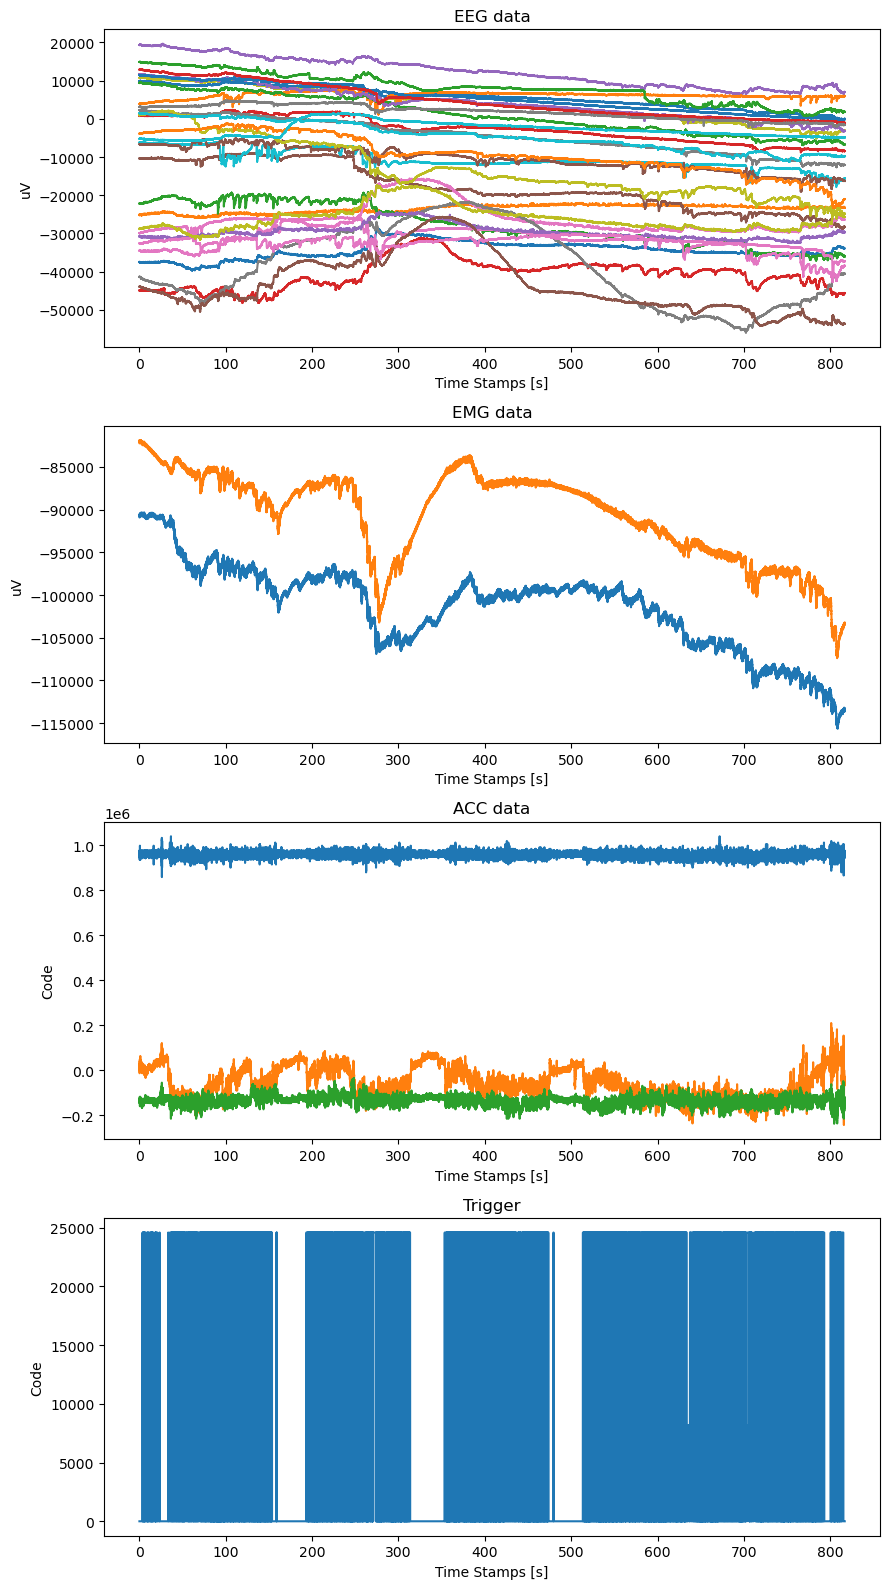

In [30]:
# Plot EEG data
fig, ax = plt.subplots(4, 1, figsize=(9, 16))

i = 0
ax[i].plot(eeg_t, eeg_data[:, :30])
ax[i].set_ylabel('uV')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('EEG data')

i += 1
ax[i].plot(eeg_t, eeg_data[:, 30:32])
ax[i].set_ylabel('uV')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('EMG data')

i += 1
ax[i].plot(eeg_t, eeg_data[:, 32:35])
ax[i].set_ylabel('Code')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('ACC data')

# skip packet counter plot

i += 1
ax[i].plot(eeg_t, eeg_data[:, 36])
ax[i].set_ylabel('Code')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('Trigger')

'''
# Plot event markers
for i in range(len(events)):
    event_t = events_t[i]
    event_v = events[i][0]
    event_type = events[i][1]
    
    if event_type == 'left':
        ax[0].axvline(x = event_t, c='pink')
    elif event_type == 'right':
        ax[0].axvline(x = event_t, c='c')
    elif event_type == 'enter':
        ax[0].axvline(x = event_t, c='r')
    
ax[1].plot(z_t, z_data)
ax[1].set_ylabel('kOhms')
ax[1].set_title('Impedance')

'''

plt.tight_layout()
plt.show()

# Prepare to import data to mne

## Rescale EEG data to V
(only run this once!)

In [31]:
print(eeg_data[:, 0])

# Rescale units of eeg_data to V
if 'microvolts' in eeg_ch_units:
    eeg_data[:, :32] /= 1e6 # only rescale EEG and ExG channels
    
print(eeg_data[:, 0])

[-37538.562 -37543.83  -37545.86  ... -33943.5   -33943.773 -33939.027]
[-0.03753856 -0.03754383 -0.03754586 ... -0.0339435  -0.03394377
 -0.03393903]


In [32]:
eeg_data.T.shape # mne expects (n_channels, n_times)

(37, 408409)

In [33]:
eeg_ch_names

['AF7',
 'Fpz',
 'F7',
 'Fz',
 'T7',
 'FC6',
 'Fp1',
 'F4',
 'C4',
 'Oz',
 'CP6',
 'Cz',
 'PO8',
 'CP5',
 'O2',
 'O1',
 'P3',
 'P4',
 'P7',
 'P8',
 'Pz',
 'PO7',
 'T8',
 'C3',
 'Fp2',
 'F3',
 'F8',
 'FC5',
 'AF8',
 'A2',
 'ExG 1',
 'ExG 2',
 'ACC32',
 'ACC33',
 'ACC34',
 'Packet Counter',
 'TRIGGER']

(Manually) Identify each channel's type for importing data to mne:

In [34]:
ch_types = []
ch_types.extend(['eeg']*30) # first 30 channels are EEG (including A2)
ch_types.extend(['misc']*(2+3+1)) # ExG x2, ACC x3, Packet Counter)
ch_types.extend(['stim']) # Trigger channel (probably unused)

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [35]:
info = mne.create_info(
    ch_names = eeg_ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [36]:
raw = mne.io.RawArray(
    data = eeg_data.T, # mne expects (n_channels, n_times)
    info = info,
)

raw

Creating RawArray with float64 data, n_channels=37, n_times=408409
    Range : 0 ... 408408 =      0.000 ...   816.824 secs
Ready.


<RawArray | 37 x 408409 (816.8 s), ~115.3 MB, data loaded>

## Apply the 10-20 channel montage

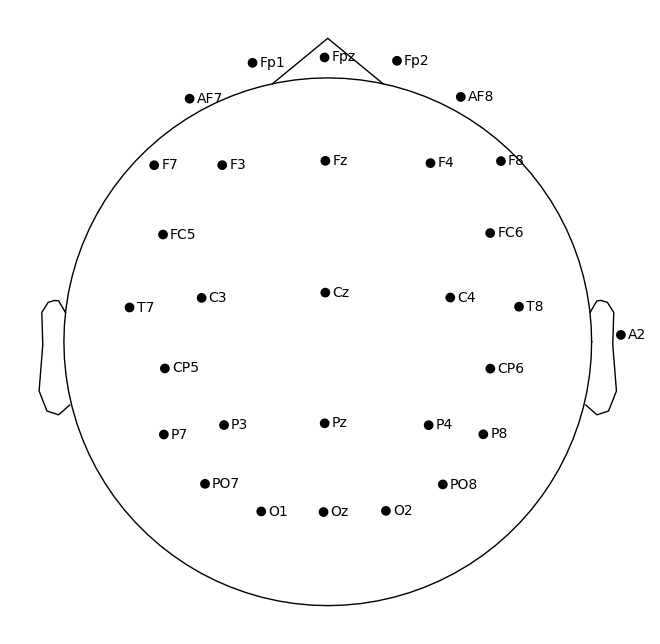

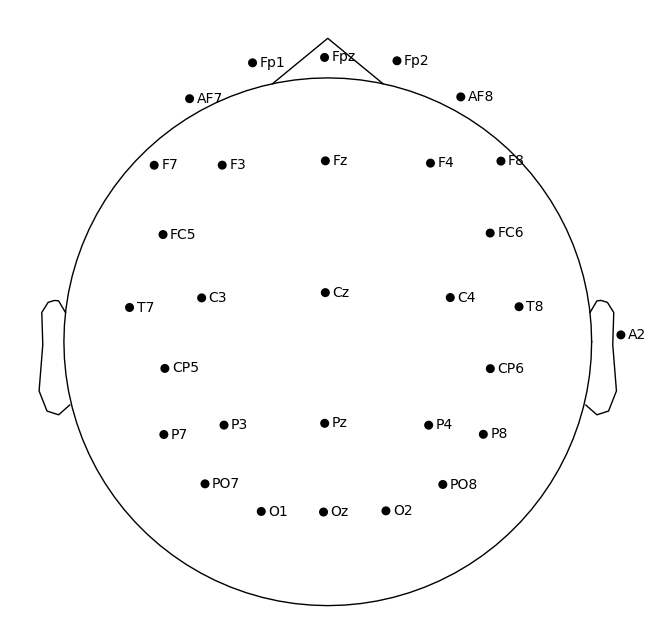

In [37]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

# Add annotations from MIDI stream

In [38]:
lsl_streams['MIDI']

{'data': array([[  0,  60, 113],
        [  0,  60,  64],
        [  0,  48, 116],
        ...,
        [  0,  50,  64],
        [  0,  60, 118],
        [  0,  60,  64]], dtype=int32),
 'time': array([ 35.15643459,  35.25257527,  36.38961551, ..., 791.66065554,
        792.62703634, 792.72558375])}

In [39]:
midi_q = {}
midi_events = []

for i, msg in enumerate(lsl_streams['MIDI']['data']):
    
    _ = msg[0] # could set this to be note_on or note_off events
    note = msg[1]
    velocity = msg[2]
    
    if not note in midi_q:
        on_t = lsl_streams['MIDI']['time'][i]
        midi_q[note] = {}
        midi_q[note]['onset'] = on_t
        midi_q[note]['velocity'] = velocity
        
    else: # note is already ON
        if velocity == 64: # OFF event
            off_t = lsl_streams['MIDI']['time'][i]
            midi_events.append(
                [
                    midi_q[note]['onset'], # start time
                    off_t - midi_q[note]['onset'], # duration
                    librosa.midi_to_note(note)
                ]
            )
            midi_q.pop(note, None) # remove note from the queue
            
midi_events = np.array(midi_events) # for easier indexing
midi_events

array([['35.156434591743164', '0.09614067478105426', 'C4'],
       ['36.389615506865084', '0.08385238435585052', 'C3'],
       ['37.14109707425814', '0.04357799876015633', 'F3'],
       ...,
       ['790.3323911777698', '0.08996831194963306', 'C3'],
       ['791.5999861869495', '0.06066935055423528', 'D3'],
       ['792.6270363408839', '0.09854740998707712', 'C4']], dtype='<U32')

In [40]:
# Total notes played
len(midi_events)/2 # halved as each key press would get an ON and OFF event

824.0

https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html

In [41]:
lsl_annot = mne.Annotations(
    onset = midi_events[:, 0],
    duration = midi_events[:, 1], # setting durations to 0 to just label event onsets
    description = midi_events[:, 2]
)

raw.set_annotations(lsl_annot)

<RawArray | 37 x 408409 (816.8 s), ~115.3 MB, data loaded>

Using matplotlib as 2D backend.


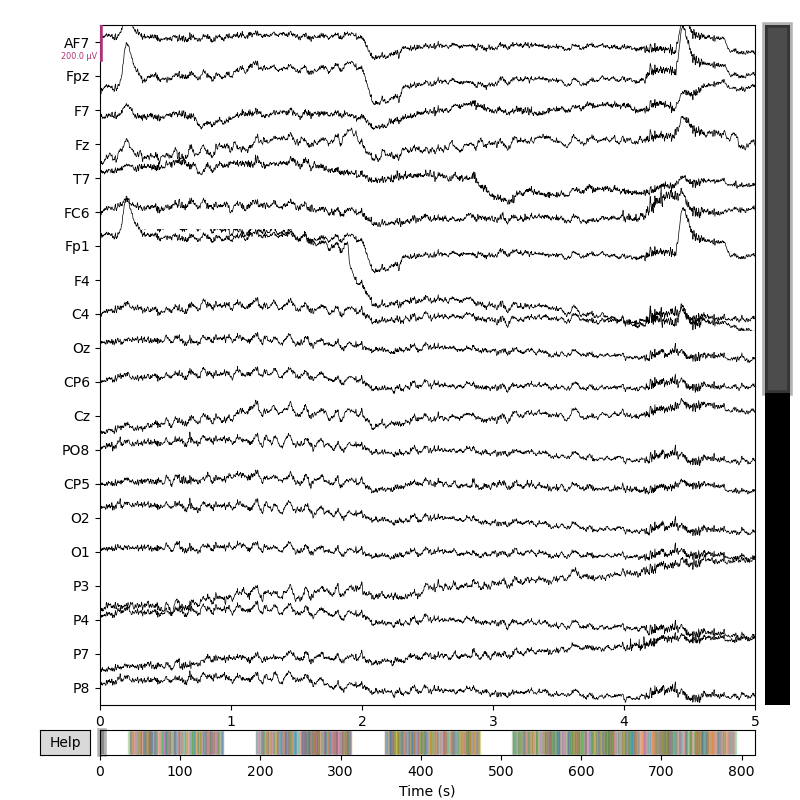

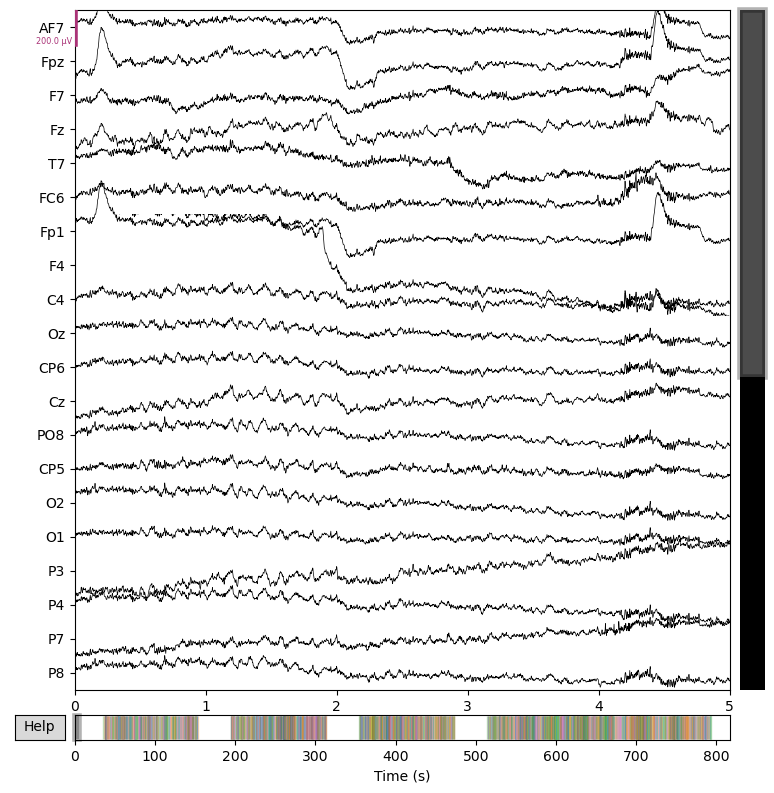

In [42]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 100e-6, 
    'eog': 500e-6,
    'misc': 100
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 5

raw.plot(
    scalings = scalings,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)